In [2]:
import numpy as np
import pandas as pd
import cv2
from random import randint
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
from losers import bce_dice_loss, dice_loss, dice_coeff, jaccard_loss, bce_jacard_loss
from helpers import create_dataset_from_tfrecord, create_dataset_from_directory, create_deserializer, get_test_generator, create_data_set_from_generator
from augs import tf_augs, tf_alldir_augs, tf_alldir_rotate_augs, get_tf_pad, norm_and_float
from models import build_model, build_model_1layer, UnetModel
from helpers import get_reshaper
import tensorflow as tf
from util import create_coverage_stratas, get_paths, print_history

In [3]:
def expand_dims(img, mask):
    return tf.expand_dims(img, -1), tf.expand_dims(mask, -1) 

In [21]:
train_ds = create_dataset_from_directory('./tfrecords/tfrecords101_int/train', create_deserializer(shape=(101, 101), _type=tf.int64, augmentations=[get_tf_pad(), expand_dims, norm_and_float, tf_alldir_augs]), batch_size=32)


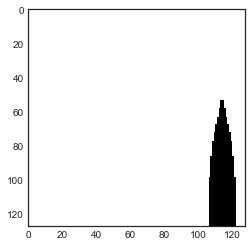

In [19]:
img = a[1][11].squeeze().astype(np.uint8)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [24]:
input_layer = tf.keras.layers.Input((128, 128, 1))
output_layer = build_model(input_layer, 32)

model = tf.keras.models.Model(input_layer, output_layer)
# optimizer=tf.train.AdamOptimizer(0.0002)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", dice_coeff])
train_ds = create_dataset_from_directory('./tfrecords/tfrecords101_int/train', create_deserializer(shape=(101, 101), _type=tf.int64, augmentations=[get_tf_pad(), expand_dims, norm_and_float, tf_alldir_augs]), batch_size=32)

test_ds = create_dataset_from_directory('./tfrecords/tfrecords101/validation', create_deserializer(shape=(101, 101), _type=tf.int64, augmentations=[get_tf_pad(),  expand_dims, norm_and_float]), batch_size=32)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard('./comb_model', histogram_freq=1)
# tbc=TensorBoardColab()
epochs = 200
batch_size = 20
train_ds = train_ds.shuffle(32)
train_ds = train_ds.repeat(200)
history = model.fit(train_ds, validation_data=test_ds,validation_steps=25,steps_per_epoch=100,
                    epochs=200,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 99/100 [============================>.] - ETA: 1s - loss: 18.1280 - acc: 0.7484 - dice_coeff: 0.2688

InvalidArgumentError: Key: mask.  Data types don't match. Data type: float but expected type: int64
	 [[{{node ParseSingleExample/ParseSingleExample}}]]
	 [[{{node IteratorGetNext_4}}]]
	 [[{{node IteratorGetNext_4}}]]